# Machine learning in Electron Microscopy:

## Dimensionality reduction and blind source separation

Requires **HyperSpy v1.3** or above.

## Summary

This tutorial shows how to perform matrix factorization and blind source separation on spectra using HyperSpy. The same procedure can be used to analyse objects of higher dimensionality.

## Credits and changes

* 31/07/2019 Joshua Taillon. Update for HyperSpy v1.5.1 and 2019 M&M workshop.
* 23/08/2016 Michael Walls. Extra explanations.
* 27/07/2016 Francisco de la Peña. Updated for HyperSpy v1.0.1.
* 06/03/2016 Francisco de la Peña. Adapted from previous tutorials for the SCANDEM workshop.

## Table of contents

1. [PCA via SVD](#PCA)
2. [Blind source separation](#BSS)
3. [Pre-processing](#preprocessing)


## <a id='PCA'></a> 1. Principle Component Analysis (PCA) via singular value decomposition (SVD)

This is a powerful method for reducing noise in hyperspectral datasets. Here we begin with a few lines of matrix algebra outlining the principles of the technique, but the demo can be followed easily without a full understanding of the mathematics. As with the "getting started" demo you can run this one interactively by downloading it and saving it as a .ipynb file.

Lets start by supposing a line-spectrum $D$ that can be described by a
linear model:

$$D=\left[d_{i,j}\right]_{m\times n}={\displaystyle \left[{\color{green}p_{i,j}}\right]_{m\times{\color{red}l}}\times}\left[{\color{red}{\color{blue}s_{i,j}}}\right]_{{\color{red}l}\times n}$$

where $m$ is the *number of pixels* in the line scan, $n$ the *number of channels* in the spectrum and $l$ the *number of components* e.g. spectra of individual compounds.

Normally, what we actually measure is a noisy version of $D$, which we will call $D'$:

$$D'={\displaystyle \left[d'_{i,j}\right]_{m\times n}=\left[{\color{green}p_{i,j}}\right]_{m\times{\color{red}l}}\times}\left[{\color{red}{\color{blue}s_{i,j}}}\right]_{{\color{red}l}\times n}+\mathrm{Noise}$$


$D'$ could be factorized as follows:

$$D'={\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}k}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}k}\times n}$$ 

where $k\leq\min\left(m,n\right)$.

Extra constraints are needed to fully determine the matrix factorization. When we add the orthogonality constraint we refer to this decomposition as singular value decomposition (SVD &mdash; see the [wiki entry](https://en.wikipedia.org/wiki/Singular_value_decomposition) for further details).

In our assumption of a linear model:

$$D'={\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}l}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}l}\times n}+
{\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}{k-l}}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}{k-l}}\times n}$$

With 

$$D\approx{\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}l}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}l}\times n}$$

and

$$\mathrm{Noise}\approx{\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}{k-l}}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}{k-l}}\times n}$$


 

Since the data for this demo is included with the tutorial files, we begin by activating the matplotlib backend, importing HyperSpy, and loading a dataset.   

### Set up matplotlib and import Hyperspy

**NOTE**: You can use either the `notebook` or `qt` backends for matplotlib (whichever you prefer). Using `notebook` will leave the generated figures saved in the notebook document by default, which may be preferred for posterity's sake, but `qt` makes it easier to drag windows around and visualize things.

In [1]:
# Set the matplotlib backend
%matplotlib notebook 

# Import hyperspy
import hyperspy.api as hs

### Load a dataset

In [2]:
# Load a synthetic EELS dataset for machine learning signal separation
s = hs.load("data/CL1.hdf5")

This is a synthetic electron energy-loss spectroscopy dataset. The procedure, although not fully general, can easily be used as is or with minor adaptation to analyse other kinds of data including images and higher dimensional signals.

<IPython.core.display.Javascript object>


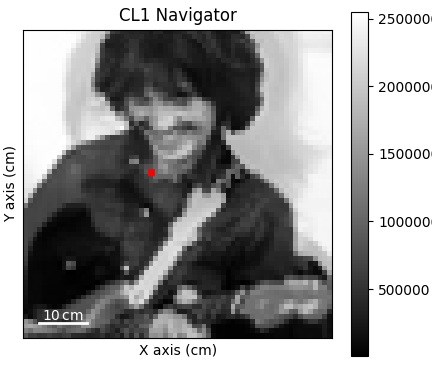

<IPython.core.display.Javascript object>


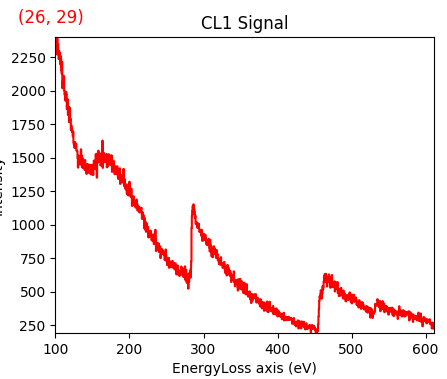

In [3]:
# plot the loaded signal
s.plot()

To perform SVD in HyperSpy we use the `decomposition` method that, by default, performs SVD.

In [4]:
# Perform a signal decomposition using SVD
s.decomposition()

The result of the decomposition is stored in the `learning_results` attribute.

In [5]:
# Print a summary of the machine learning results
s.learning_results.summary()

Decomposition parameters:
-------------------------

Decomposition algorithm : 	svd
Poissonian noise normalization : False
Output dimension : None
Centre : None


SVD decomposes the data into so-called "components" and sorts them in order of decreasing relevance. It is often useful to estimate the dimensionality of the data by plotting the explained variance against the component index on a logarithmic y-scale. This plot is sometimes called a [Scree plot](https://en.wikipedia.org/wiki/Scree_plot) and it should drop quickly, eventually becoming a slowly descending line. The point at which it becomes linear (the elbow point) is often a good estimation of the dimensionality of the data (or equivalently, the number of components that should be retained). It should be noted that this estimate is an empirical rule (it is used because it usually works), and there is some subjectivity in noisy or weak signals (the elbow point may not be well defined).

To plot the scree plot, run the `plot_explained_variance_ratio` method e.g.:


<IPython.core.display.Javascript object>


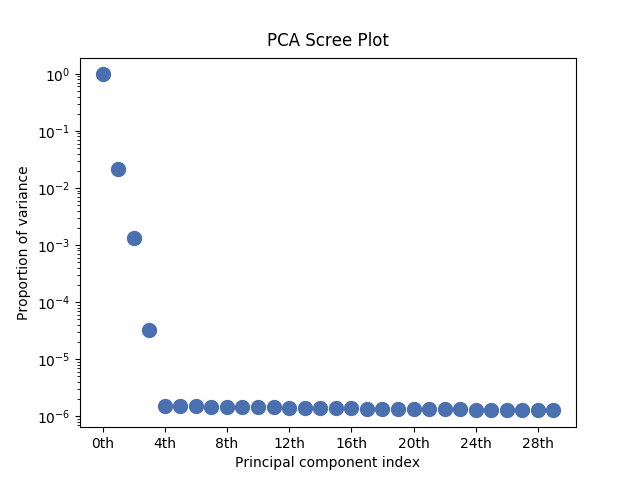

In [6]:
# Plot the "explained variance ratio" (scree plot)
_ = s.plot_explained_variance_ratio()

From the scree plot we estimate that there are 4 principal components.

We can store the data used to create the scree plot as a `Spectrum` instance using the following method:

In [7]:
# Get the explained variance ratio
scree_plot = s.get_explained_variance_ratio()

### Shot noise

PCA assumes gaussian noise, however, the noise in EELS (and many other EM) spectra is approximately poissonian (shot noise). It is possible to approximately "normalise" the noise by using a liner transformation, which should result in a better decomposition of data with shot noise. This is done in HyperSpy as follows:

In [8]:
# Perform the decomposition, normalizing poissonian noise
s.decomposition(normalize_poissonian_noise=True)

Let's plot the scree plot of this and the previous decomposition in the same figure

<IPython.core.display.Javascript object>


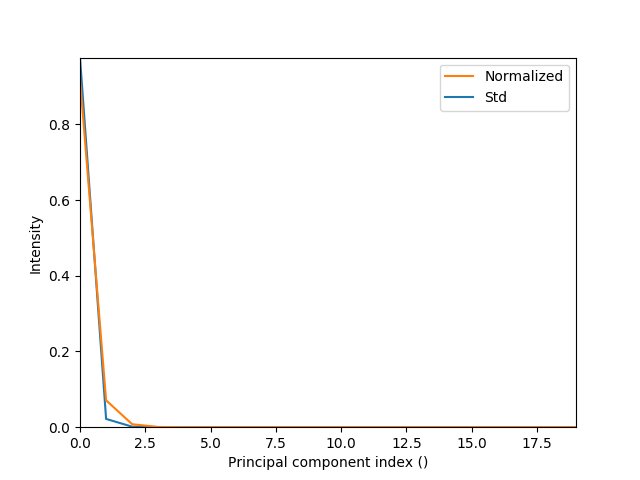

In [9]:
# Plot the non-normalized variance data vs. the normalized:
ax = hs.plot.plot_spectra([scree_plot.isig[:20],
                          s.get_explained_variance_ratio().isig[:20]],
                          legend=("Std", "Normalized"))

Let's improve the plot using some [matplotlib](http://matplotlib.org/) commands:

<IPython.core.display.Javascript object>


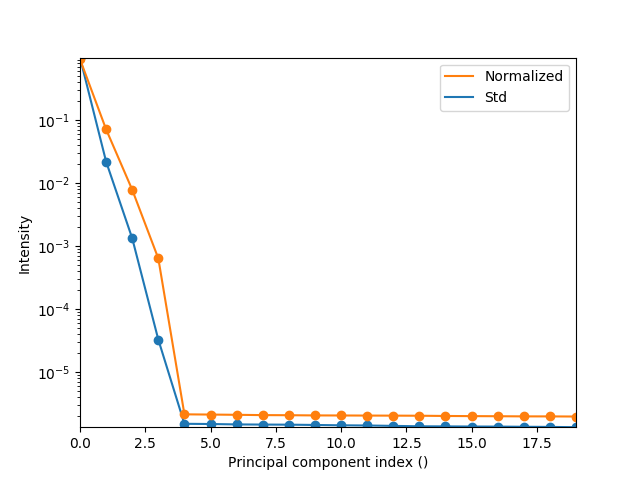

In [10]:
# Do the same as above, but improve the plot by changing to a log scale
#  and adding some markers for the data points
ax = hs.plot.plot_spectra([scree_plot.isig[:20],
                          s.get_explained_variance_ratio().isig[:20]],
                          legend=("Std", "Normalized"))

ax.set_yscale('log')
ax.lines[0].set_marker("o")
ax.lines[1].set_marker("o")

As we can see, the explained variance of the first four components of the normalized decomposition are "further away" from the noise than those of the original data, indicating a better decomposition.

### Visualise the decomposition results

The following commands can be used to plot the first $n$ principal components.
(Note: the `_=` part at the beginning is for webpage rendering purposes and is not strictly needed in the command) 

<IPython.core.display.Javascript object>


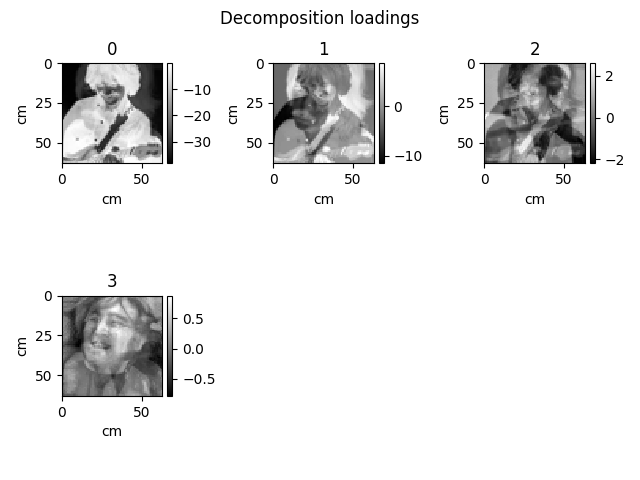

<IPython.core.display.Javascript object>


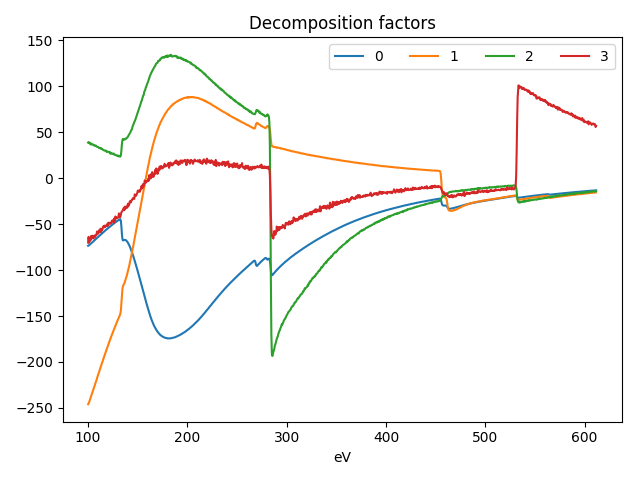

In [11]:
# Plot the first four principle components (loadings and factors)
_ = s.plot_decomposition_loadings(4)
_ = s.plot_decomposition_factors(4)

Alternatively (and usually more conveniently) we can use the following plotting method. Use the slider or the left/right arrow keys to change the index of the components in interactive plotting mode. 

<IPython.core.display.Javascript object>


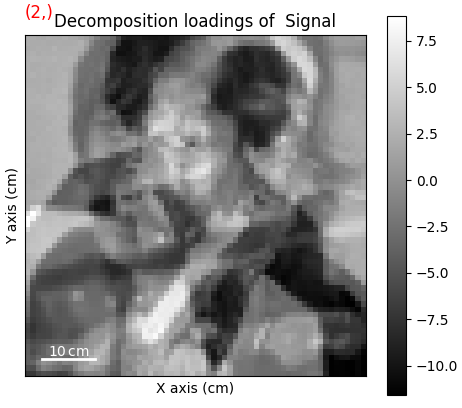

<IPython.core.display.Javascript object>


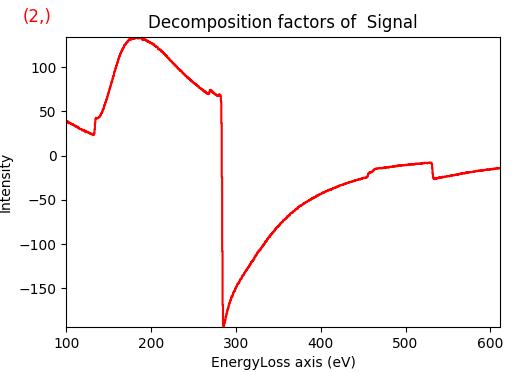

In [12]:
# Plot the PCA results with one command:
s.plot_decomposition_results()

### Noise reduction

A common application of PCA is noise reduction, which is achieved by dimensionality reduction. We can create a "denoised" version of the dataset by inverting the decomposition using only the number of principal components that we want to retain (in this case the first 4 components). This is done with the `get_decomposition_model` command.

In [13]:
# Obtain a dimension-reduced model using four components from the PCA decomposition
sc = s.get_decomposition_model(4)

Let's plot the spectra at coordinates (30,30) from the original and PCA-denoised datasets. By multiplying one of the signals by $i$ (the imaginary unit &mdash; represented by `1j` in Python), we create a new complex signal that allows us to see both spectrum images at once:

<IPython.core.display.Javascript object>


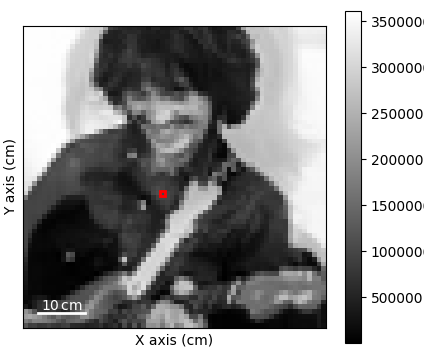

<IPython.core.display.Javascript object>


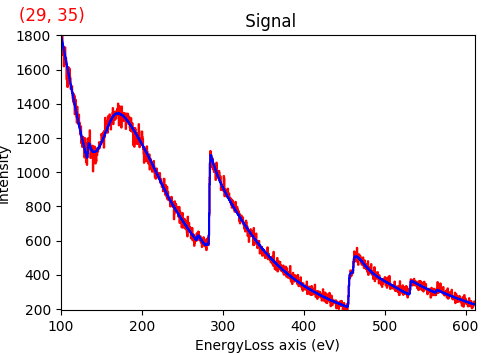

In [14]:
# Compare the original signal to the dimensional-reduced model using a complex signal (and plot):
(s + sc * 1j).plot()

Calculating and plotting the residuals at a given position can be done in one single line

<IPython.core.display.Javascript object>


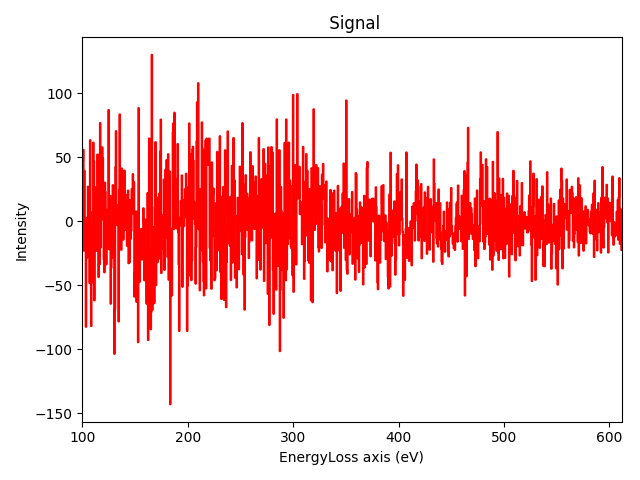

In [15]:
# Plot the residual between the signal and PCA-model at one pixel:
(s - sc).inav[30,30].plot()

We can also calculate the residuals and plot them as a spectrum image to see that we have captured (almost) all of the signal structure in the first four principle components:

<IPython.core.display.Javascript object>


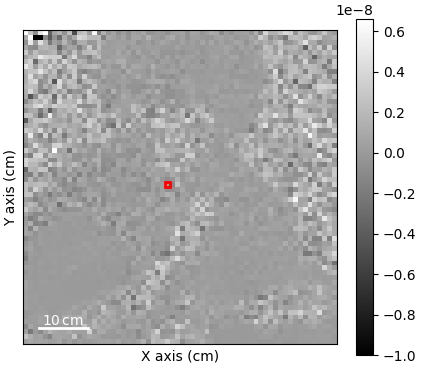

<IPython.core.display.Javascript object>


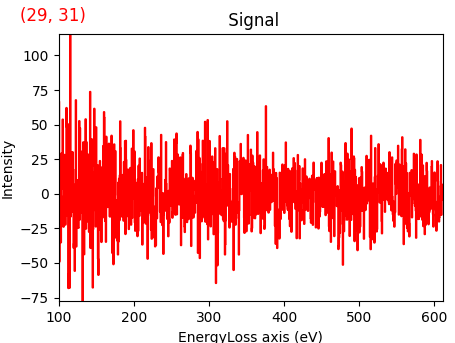

In [16]:
# Plot the residual between the signal and PCA-model as a spectrum image:
(s - sc).plot()

## <a id='BSS'></a> 2. Blind source separation

### Independent component analysis

As we have seen in the previous section, the principal components are a linear mixture of EELS elemental maps and spectra, but the mixing matrix is unknown. We can use blind source separation (BSS) to estimate the mixing matrix. In this case we will use independent component analysis. BSS is performed in HyperSpy using the `blind_source_separation` method that by default uses "[FastICA](https://en.wikipedia.org/wiki/FastICA)" which is a well-tested ICA routine implemented in [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html).

By default, the BSS is performed on the first derivative of the signal, which often results in a better separation:

In [17]:
# Perform BSS on the first derivative of the first four PCA components
s.blind_source_separation(4, diff_order=1)

The results are also stored in the `learning_results` attribute:

In [18]:
# Show the learning results summary:
s.learning_results.summary()

Decomposition parameters:
-------------------------

Decomposition algorithm : 	svd
Poissonian noise normalization : True
Output dimension : None
Centre : None

Demixing parameters:
------------------------
BSS algorithm : sklearn_fasticaNumber of components : 4


And can be visualised with the following commands:

<IPython.core.display.Javascript object>


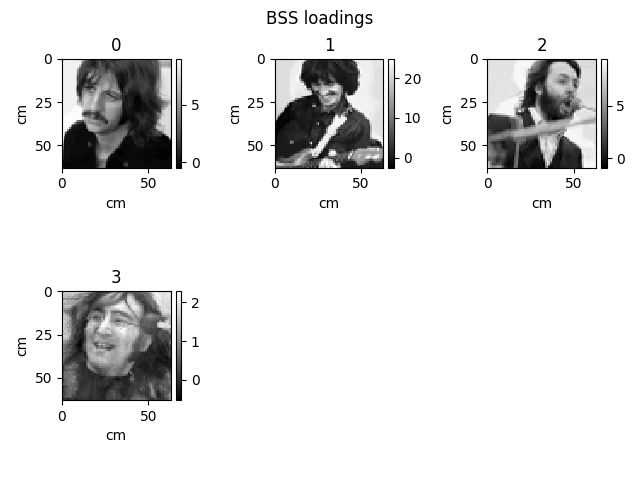

<IPython.core.display.Javascript object>


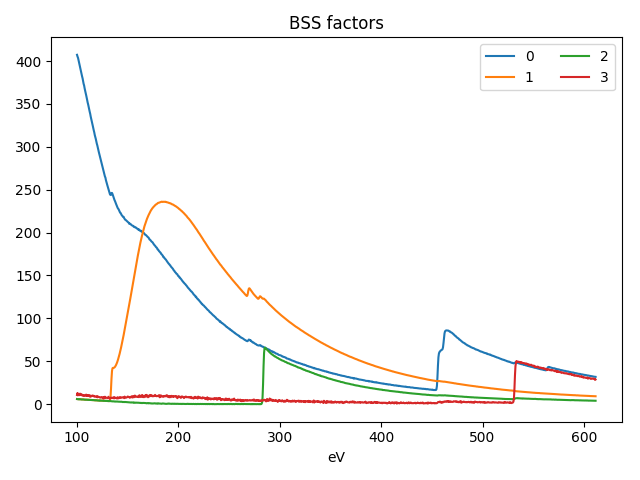

In [19]:
# Plot the loadings and factors resulting from the BSS demixing
_ = s.plot_bss_loadings()
_ = s.plot_bss_factors()

Or usually more conveniently:

<IPython.core.display.Javascript object>


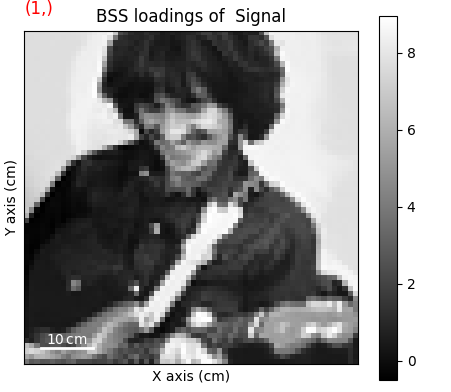

<IPython.core.display.Javascript object>


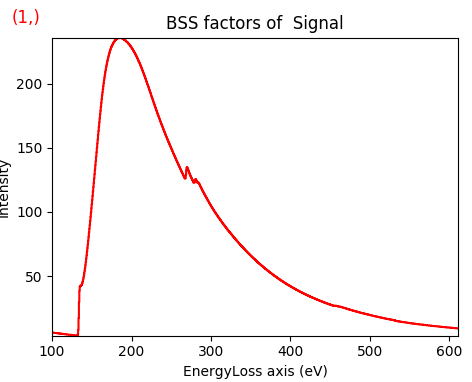

In [20]:
# Plot the BSS results in one command:
s.plot_bss_results()

### Non-negative matrix factorization

By using a different matrix factorization method, non-negative matrix factorization (NMF) we can decompose the data into "elemental" components directly. NMF replaces the orthogonality constraint in SVD by a positivity constraint.

In [21]:
# Perform a signal decomposition using the NMF algorithm instead of SVD:
s.decomposition(True, algorithm="nmf", output_dimension=4)

<IPython.core.display.Javascript object>


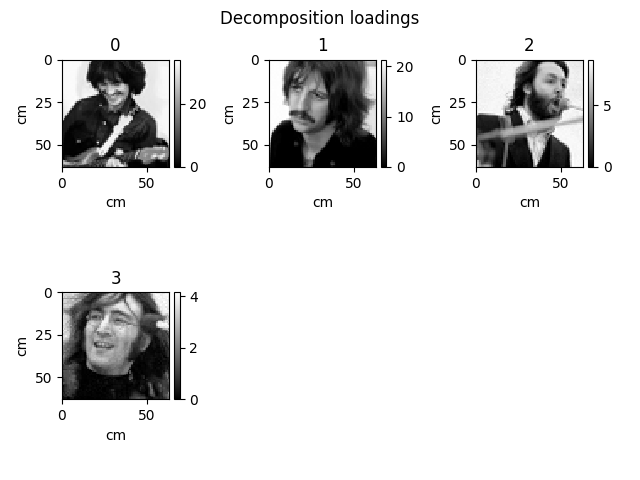

<IPython.core.display.Javascript object>


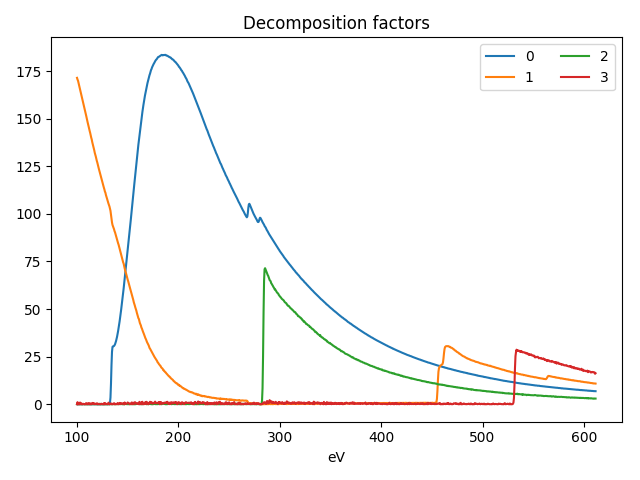

In [22]:
# Plot the results of the NMF decomposition (in two lines)
_ = s.plot_decomposition_loadings()
_ = s.plot_decomposition_factors()

ICA and NMF both do a good job, NMF being slightly better in this case. However, some mixing remains in both cases. In the case of ICA the main cause is noise as we will show by analysing in the same way an identical dataset with less noise.

### Investigating effect of noise

In [ ]:
# Load the same dataset as before, but without any noise present
s2 = hs.load("data/CL2.hdf5")

In [ ]:
# Perform the PCA using SVD:
s2.decomposition(True)

In [ ]:
# Demix the results using the second derivative this time for BSS:
s2.blind_source_separation(4, diff_order=2)

<IPython.core.display.Javascript object>


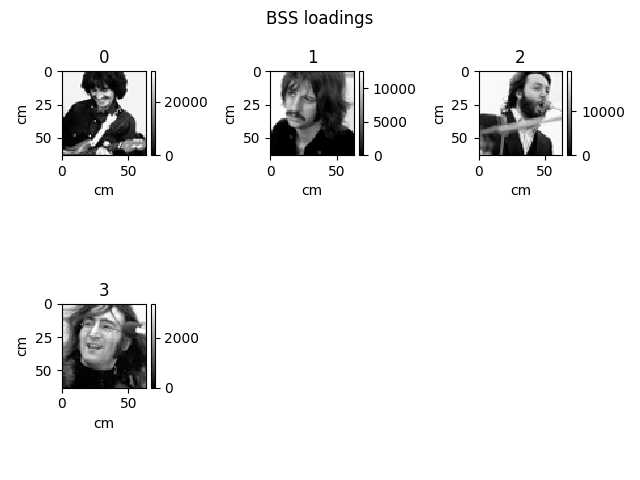

<IPython.core.display.Javascript object>


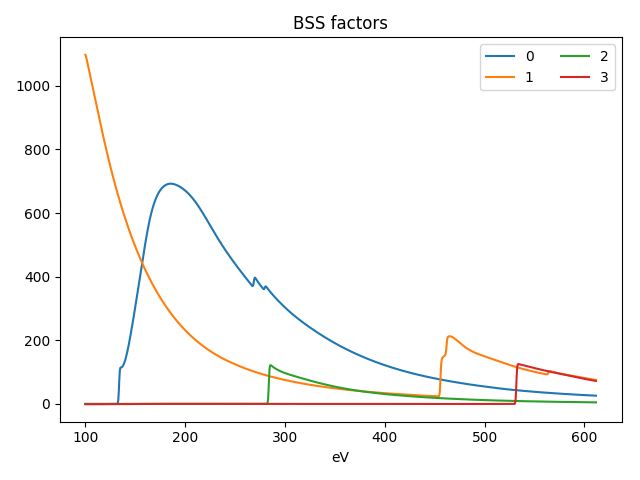

In [23]:
# Plot the results
_ = s2.plot_bss_loadings()
_ = s2.plot_bss_factors()

Note that the better SNR permits using a second numerical derivative which enhances the independence of the sources, improving the performance of ICA in this case.

In [ ]:
# Repeat the NMF process for the noiseless signal:
s2.decomposition(True, algorithm="nmf", output_dimension=4)

<IPython.core.display.Javascript object>


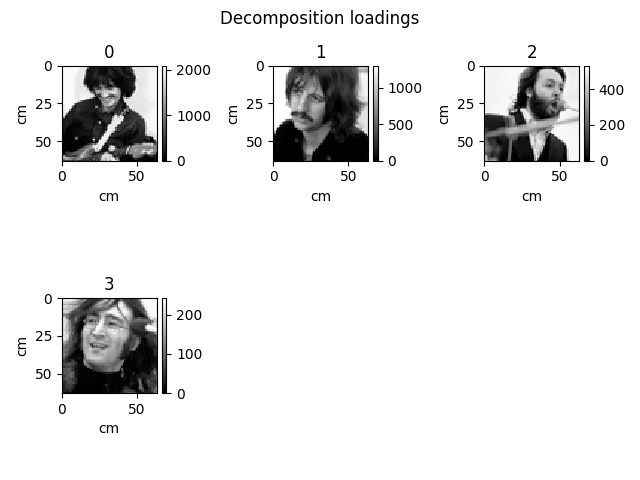

<IPython.core.display.Javascript object>


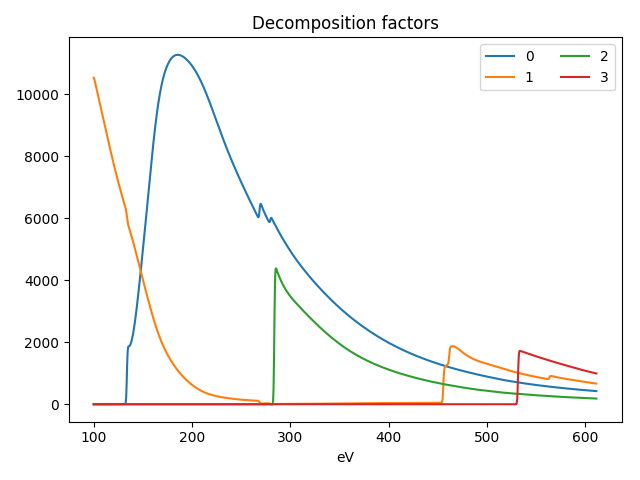

In [24]:
# plot the results
_ = s2.plot_decomposition_loadings()
_ = s2.plot_decomposition_factors()

For this dataset with better SNR ICA outperforms NMF

## <a id='preprocessing'></a>3. Pre-processing for EELS signal separation

EELS datasets sometime suffer from energy instability. This introduces a non-linearity in the data, resulting in a higher number of components than there are genuine spectral signatures coming from the object. As an example let's have a look at the `CL3` dataset.

In [25]:
# Load the same data, but with energy instability
s3 = hs.load("data/CL3.hdf5")

<IPython.core.display.Javascript object>


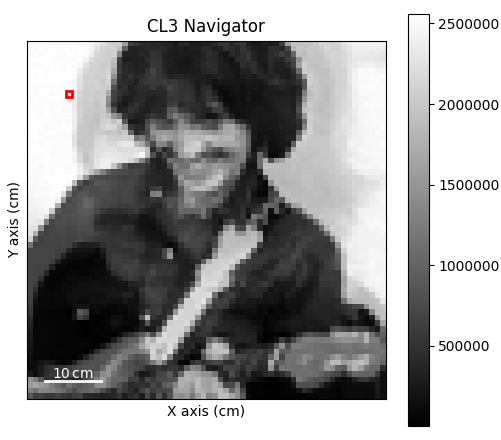

<IPython.core.display.Javascript object>


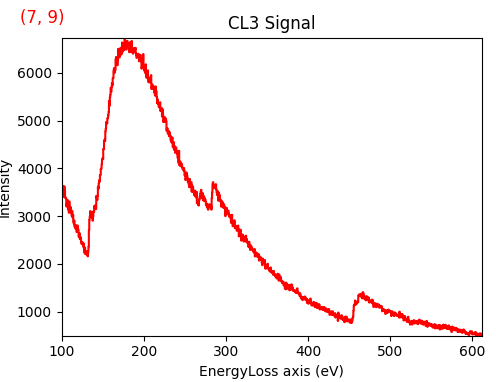

In [26]:
# Plot and inspect the signal
s3.plot()

In [27]:
# Perform the PCA
s3.decomposition(True)

<IPython.core.display.Javascript object>


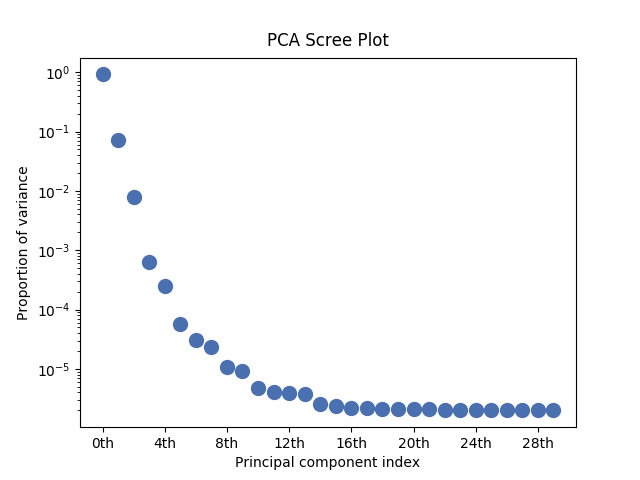

In [28]:
# Plot a scree plot (explained variance)
_ = s3.plot_explained_variance_ratio()

The scree plot now suggests that we need more components to accurately explain this dataset.

In this case we can partially correct the energy instability using the low-loss spectrum image contained in the `LL.hdf5` file. (To do this with real data you would need the low-loss spectra simultaneously acquired, using a dual EELS camera)

In [29]:
# Load the corresponding zero/low-loss data
ll3 = hs.load("data/LL3.hdf5")

<IPython.core.display.Javascript object>


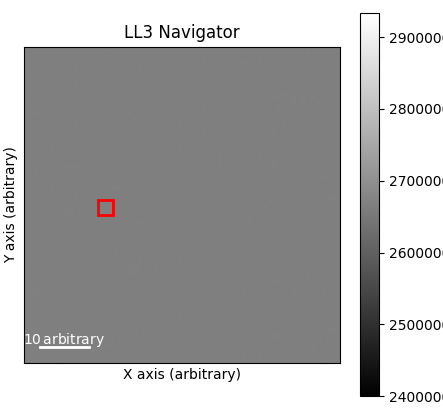

<IPython.core.display.Javascript object>


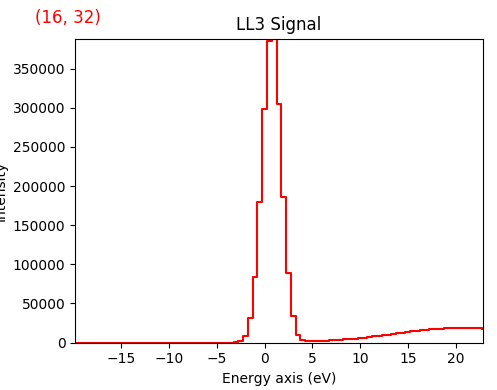

In [30]:
# Plot and inspect the low-loss data
ll3.plot()

In [31]:
# Print the contents of the ll3 object
ll3

<EELSSpectrum, title: , dimensions: (64, 64|1024)>

In [32]:
# Align the zero loss peak for the low-loss data 
# (and also the core-loss signal at the same time)
ll3.align_zero_loss_peak(also_align=[s3])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	0.00647
std:	1

min:	-3.5
Q1:	-0.5
median:	0
Q3:	0.5
max:	3.5


In [33]:
# Perform PCA on the aligned dataset
s3.decomposition(True)

<IPython.core.display.Javascript object>


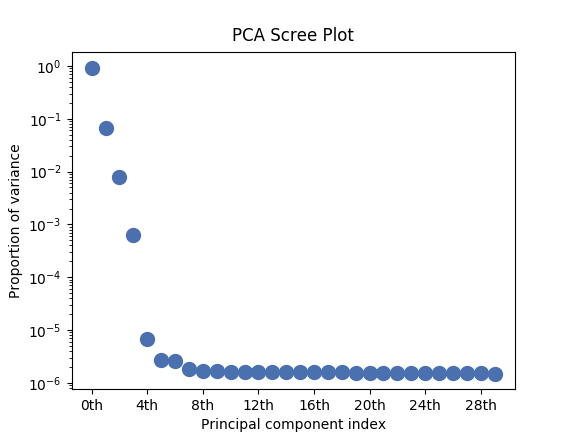

In [34]:
# Plot the resulting scree plot
s3.plot_explained_variance_ratio()

The scree plot is now more similar to the scree plot of the `CL1` dataset. However the alignment is not perfect and the scree plot still shows the effect of the remaining instability in the dataset. Nevertheless, performing BSS on the first four components results in very similar components to those of `CL1`

In [ ]:
# Perform BSS with the second derivative on the aligned signal
s3.blind_source_separation(4, diff_order=2)

<IPython.core.display.Javascript object>


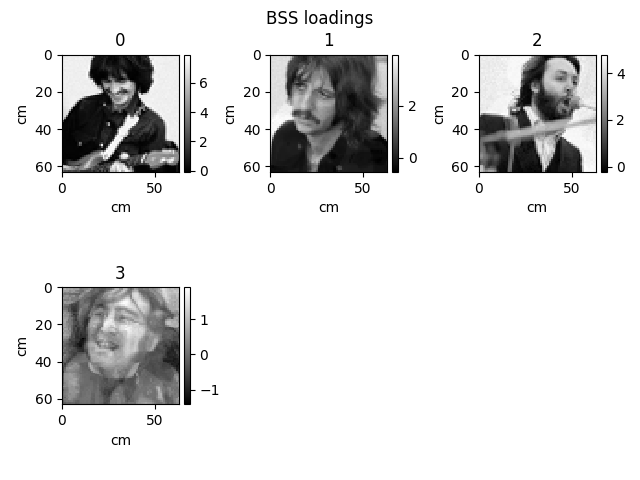

<IPython.core.display.Javascript object>


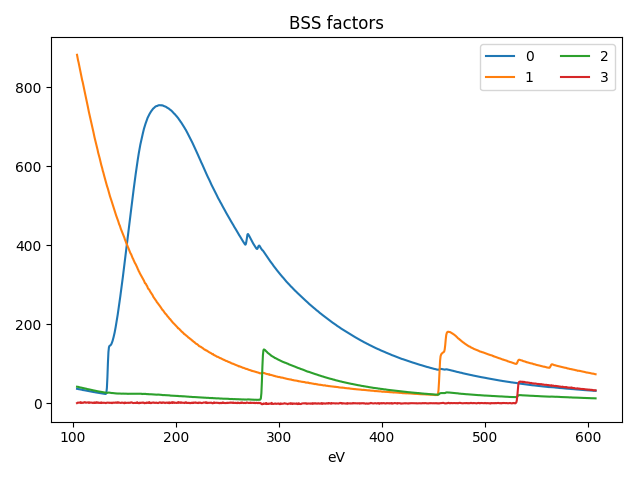

In [35]:
# Plot the BSS results
_ = s3.plot_bss_loadings()
_ = s3.plot_bss_factors()

### Signal separation with spikes and energy instabilities

Another usual complication in real data are spikes. As an example, let's load the "CL4" dataset.

In [36]:
# Load the same core-loss data, but with energy instabilities and spikes
s4 = hs.load("data/CL4.hdf5")

In [37]:
# Perform PCA on the raw data
s4.decomposition(True)

<IPython.core.display.Javascript object>


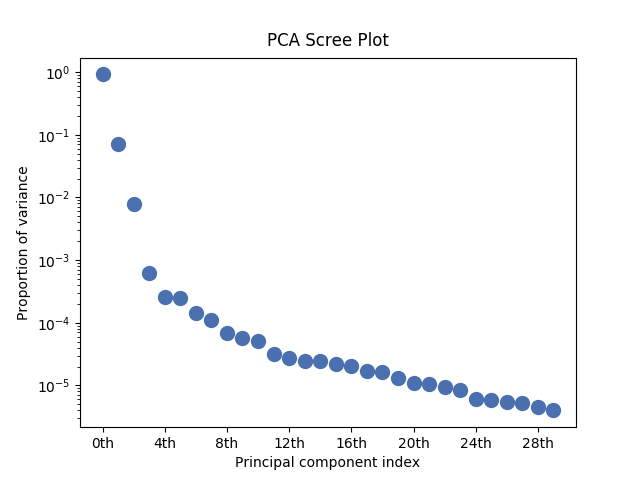

In [38]:
# Examine the scree plot
_ = s4.plot_explained_variance_ratio()

As we might expect from the scree plot output, blind source separation on this dataset performs rather poorly:

<IPython.core.display.Javascript object>


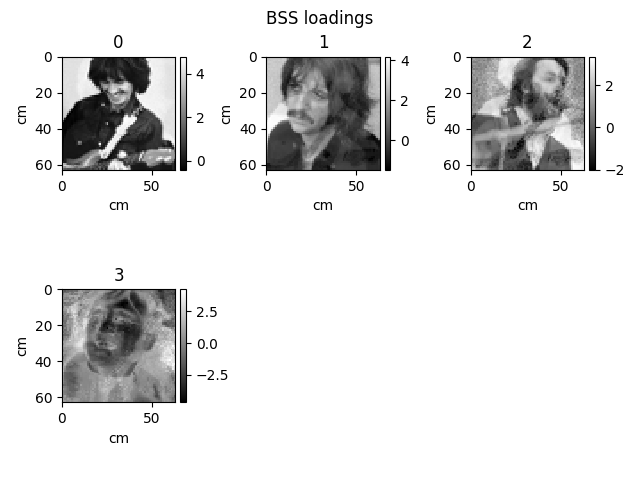

<IPython.core.display.Javascript object>


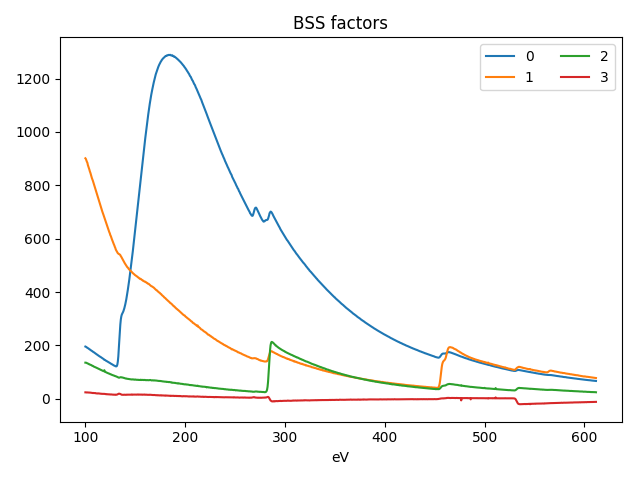

In [39]:
# Perform BSS (2nd derivative) on the raw data and plot the results
s4.blind_source_separation(4, diff_order=2)
_ = s4.plot_bss_loadings()
_ = s4.plot_bss_factors()

In this case the increase in the number of components required to explain the dataset is due to a high  number of spikes and the same energy instability as in the `CL3` dataset. We can remove the spikes using the `spikes_removal_tool`

<IPython.core.display.Javascript object>


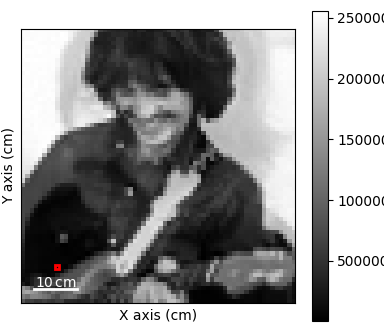

<IPython.core.display.Javascript object>


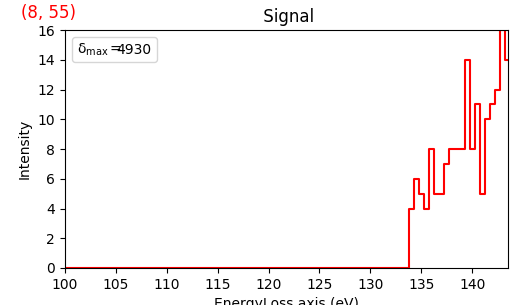

<IPython.core.display.Javascript object>


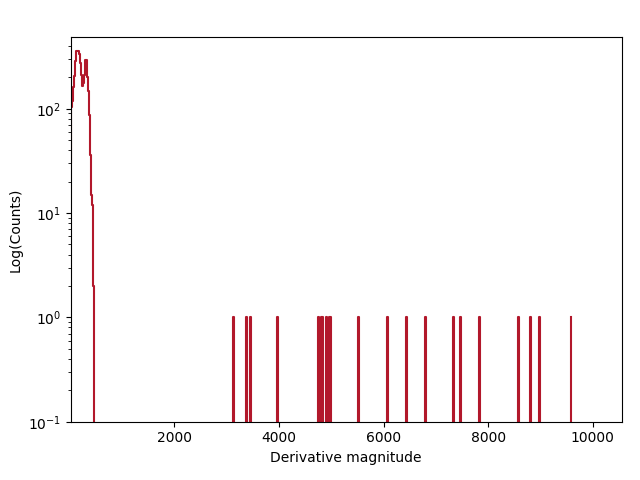

In [40]:
# Use the spikes_removal_tool to remove single-channel defects (such as X-ray spikes)
s4.spikes_removal_tool()

And the instability as above:

In [41]:
# Load the same low-loss data as before, and align it and the core-loss
ll4 = hs.load("data/LL3.hdf5")
ll4.align_zero_loss_peak(also_align=[s4])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	0.00647
std:	1

min:	-3.5
Q1:	-0.5
median:	0
Q3:	0.5
max:	3.5


In [42]:
# Now, re-run the decomposition and re-plot the scree-plot using the lines above
s4.decomposition(True)

<IPython.core.display.Javascript object>


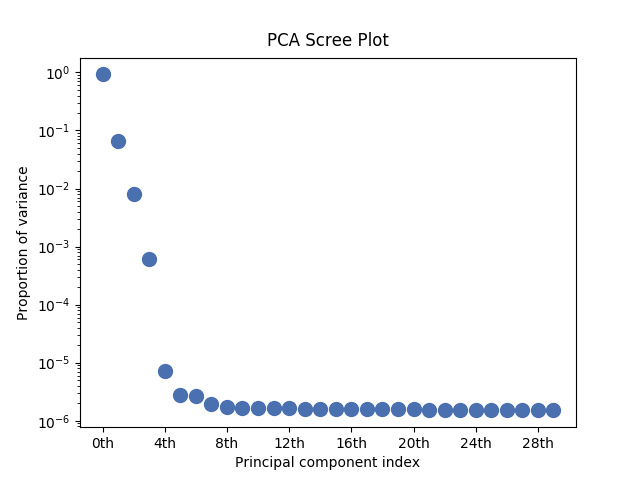

In [43]:
_ = s4.plot_explained_variance_ratio()

As expected, the scree plot has much better separation, so we expect a better result from the BSS algorithm.

In [ ]:
# Perform BSS on the processed data (2nd derivative)
s4.blind_source_separation(4, diff_order=2)

<IPython.core.display.Javascript object>


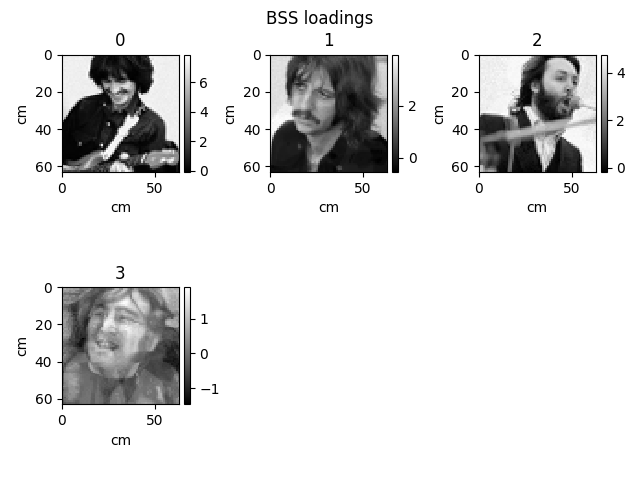

<IPython.core.display.Javascript object>


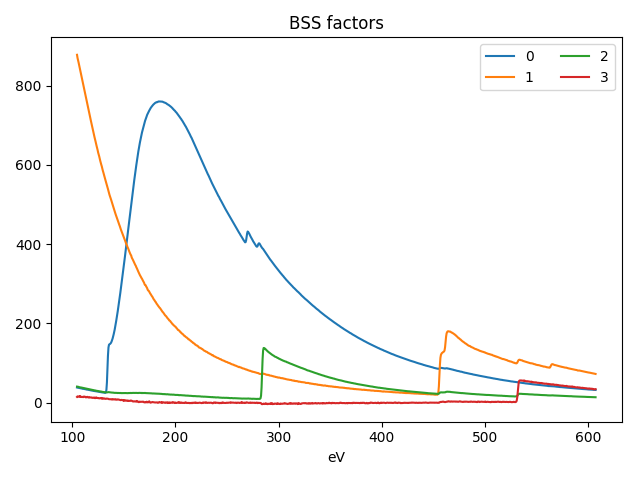

In [44]:
# Plot the BSS results
_ = s4.plot_bss_loadings()
_ = s4.plot_bss_factors()